<a href="https://colab.research.google.com/github/Matthew-Ye/Matthew-Ye.github.io/blob/master/Assignment_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [5]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-03-23 02:07:39--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  3.42MB/s    in 5m 33s  

2019-03-23 02:13:13 (4.76 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

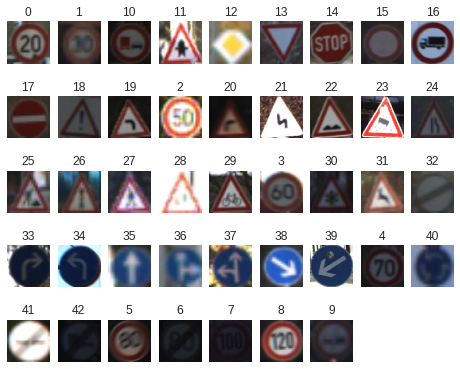

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

### Assignment 1: Multi-Layer Perceptron

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Dense(16, input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Flatten())
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 224, 224, 16)      64        
_________________________________________________________________
flatten_13 (Flatten)         (None, 802816)            0         
_________________________________________________________________
activation_25 (Activation)   (None, 802816)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 802816)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 6422536   
_________________________________________________________________
activation_26 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8)                 0         
__________

In [50]:
data = mlp.fit(tr_signs, tr_labels, batch_size=16, epochs=50, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/50
 - 3s - loss: 3.7695 - acc: 0.0417 - val_loss: 3.7555 - val_acc: 0.0833
Epoch 2/50
 - 3s - loss: 3.7525 - acc: 0.0550 - val_loss: 3.7488 - val_acc: 0.0833
Epoch 3/50
 - 3s - loss: 3.7456 - acc: 0.0700 - val_loss: 3.7416 - val_acc: 0.0833
Epoch 4/50
 - 3s - loss: 3.7387 - acc: 0.0567 - val_loss: 3.7351 - val_acc: 0.0437
Epoch 5/50
 - 3s - loss: 3.7321 - acc: 0.0700 - val_loss: 3.7283 - val_acc: 0.0833
Epoch 6/50
 - 3s - loss: 3.7255 - acc: 0.0700 - val_loss: 3.7218 - val_acc: 0.0833
Epoch 7/50
 - 3s - loss: 3.7190 - acc: 0.0700 - val_loss: 3.7154 - val_acc: 0.0833
Epoch 8/50
 - 3s - loss: 3.7127 - acc: 0.0700 - val_loss: 3.7094 - val_acc: 0.0833
Epoch 9/50
 - 3s - loss: 3.7065 - acc: 0.0700 - val_loss: 3.7032 - val_acc: 0.0833
Epoch 10/50
 - 3s - loss: 3.7004 - acc: 0.0700 - val_loss: 3.6972 - val_acc: 0.0833
Epoch 11/50
 - 3s - loss: 3.6944 - acc: 0.0700 - val_loss: 3.6913 - val_acc: 0.0833
Epoch 12/50
 - 3s - loss: 3.6885 - acc:

In [40]:
acc

0.8144044324631836

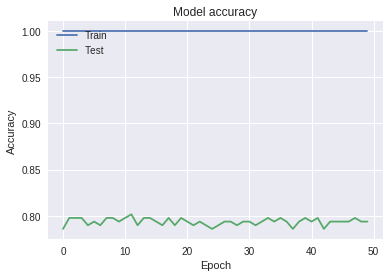

In [29]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


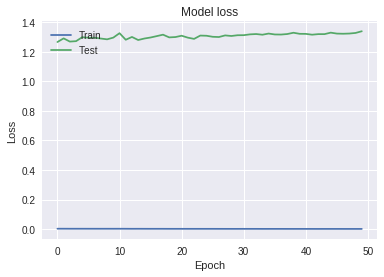

In [30]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()